# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [64]:
# Caminho local do arquivo
data = 'processed.cleveland.data'

# Ler o arquivo CSV
df = pd.read_csv(data, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])

df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [66]:
def bivariada(df, var_resposta, var_explicativa):
    # Criando uma tabela de contingência (crosstab)
    tab = pd.crosstab(df[var_explicativa], df[var_resposta], margins=True)
    tab.columns = ['Não Doente', 'Doente', 'Total']
    tab['Quantidade Média de Doentes'] = (tab['Doente'] / tab['Total']).round(2)
    tab['Odds'] = (tab['Doente'] / tab['Não Doente']).round(2)

    # Calculando o Odds Ratio usando o total como referência
    tab['Odds Ratio'] = (tab['Odds'] / tab.loc['All', 'Odds']).round(2)

    # Calculando o Logito e substitui -inf por 0
    tab['Logito'] = tab['Odds'].apply(lambda x: np.log(x) if x > 0 else 0).replace(-np.inf, 0).round(2)

    # Calculando o Weight of Evidence (WOE) e substitui -inf por 0
    tab['WOE'] = tab['Odds Ratio'].apply(lambda x: np.log(x) if x > 0 else 0).replace(-np.inf, 0).round(2)

    return tab

# 'flag_doente' é a variável resposta
# 'sex' é uma das variáveis explicativas qualitativas
bivariada_result = bivariada(df, 'flag_doente', 'sex')
print(bivariada_result)

     Não Doente  Doente  Total  Quantidade Média de Doentes  Odds  Odds Ratio  \
sex                                                                             
0.0          72      25     97                         0.26  0.35        0.41   
1.0          92     114    206                         0.55  1.24        1.46   
All         164     139    303                         0.46  0.85        1.00   

     Logito   WOE  
sex                
0.0   -1.05 -0.89  
1.0    0.22  0.38  
All   -0.16  0.00  


In [67]:
# Calculando a análise bivariada para várias variáveis explicativas
for var in ['sex', 'cp', 'fbs']:
    print(f"Análise Bivariada para {var}")
    print(bivariada(df, 'flag_doente', var))
    print()

Análise Bivariada para sex
     Não Doente  Doente  Total  Quantidade Média de Doentes  Odds  Odds Ratio  \
sex                                                                             
0.0          72      25     97                         0.26  0.35        0.41   
1.0          92     114    206                         0.55  1.24        1.46   
All         164     139    303                         0.46  0.85        1.00   

     Logito   WOE  
sex                
0.0   -1.05 -0.89  
1.0    0.22  0.38  
All   -0.16  0.00  

Análise Bivariada para cp
     Não Doente  Doente  Total  Quantidade Média de Doentes  Odds  Odds Ratio  \
cp                                                                              
1.0          16       7     23                         0.30  0.44        0.52   
2.0          41       9     50                         0.18  0.22        0.26   
3.0          68      18     86                         0.21  0.26        0.31   
4.0          39     105    144     

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [68]:
def bivariada_quantitativa(df, var_resposta, var_explicativa, num_grupos=5):
    # Categorizando a variável quantitativa em 'num_grupos' grupos
    df[var_explicativa + '_cat'] = pd.cut(df[var_explicativa], bins=num_grupos, labels=[str(i+1) for i in range(num_grupos)])

    # Realizando a análise bivariada para a variável categorizada
    tab = pd.crosstab(df[var_explicativa + '_cat'], df[var_resposta], margins=True)
    tab.columns = ['Não Doente', 'Doente', 'Total']
    tab['Quantidade Média de Doentes'] = (tab['Doente'] / tab['Total']).round(2)
    tab['Odds'] = (tab['Doente'] / tab['Não Doente']).round(2)

    # Calculando o Odds Ratio usando o total como referência
    tab['Odds Ratio'] = (tab['Odds'] / tab.loc['All', 'Odds']).round(2)

    # Calculando o Logito e substitui -inf por 0
    tab['Logito'] = tab['Odds'].apply(lambda x: np.log(x) if x > 0 else 0).replace(-np.inf, 0).round(2)

    # Calculando o Weight of Evidence (WOE) e substitui -inf por 0
    tab['WOE'] = tab['Odds Ratio'].apply(lambda x: np.log(x) if x > 0 else 0).replace(-np.inf, 0).round(2)

    # Removendo a coluna temporária criada para categorização
    df.drop([var_explicativa + '_cat'], axis=1, inplace=True)

    return tab

# Uso da função com a variável 'age' e 5 grupos
bivariada_result = bivariada_quantitativa(df, 'flag_doente', 'age')
print(bivariada_result)

         Não Doente  Doente  Total  Quantidade Média de Doentes  Odds  \
age_cat                                                                 
1                 8       3     11                         0.27  0.38   
2                50      21     71                         0.30  0.42   
3                56      41     97                         0.42  0.73   
4                40      67    107                         0.63  1.68   
5                10       7     17                         0.41  0.70   
All             164     139    303                         0.46  0.85   

         Odds Ratio  Logito   WOE  
age_cat                            
1              0.45   -0.97 -0.80  
2              0.49   -0.87 -0.71  
3              0.86   -0.31 -0.15  
4              1.98    0.52  0.68  
5              0.82   -0.36 -0.20  
All            1.00   -0.16  0.00  


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [69]:
# Criando a variável dependente (y) e as variáveis independentes (X)
y = df['flag_doente']
X = df[['sex', 'cp', 'trestbps', 'age']]

# Adicionando uma constante ao modelo (intercept)
X = sm.add_constant(X)

# Ajustando o modelo
model = sm.Logit(y, X)
result = model.fit()

# Sumário do modelo
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.2605
Time:                        20:37:50   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

> **Const** ou **Constante**, tem seu coeficiente -11.1167, este é o logit para um paciente cujas variáveis independentes são todas zero, a constante pode não ter uma interpretação útil no contexto do problema, mas é necessária para o cálculo.

> **Sex**, tem seu coeficiente de 1.802 e é estatisticamente significiativo, ou seja, P>|z| é 0.000 que é menor que 0.05, sugerindo que o sexo do paciente tem um forte impacto no risco de doença cardíaca.

> **Cp** ou **Tipo de Dor no Peito**, tem seu coeficiente 1.140 e é estatisticamente significiativo, ou seja, P>|z| é 0.000 que é menor que 0.05, indicando que o tipo de dor no peito tem um forte impacto no risco de doença cardíaca.

> **Trestbps** ou **Pressão Sanguínea em Repouso**, tem seu coeficiente 0.021 e é estatisticamente significiativo, ou seja, P>|z| é 0.009 que é menor que 0.05, sugerindo que a pressão sanguínea em repouso tem um efeito menor, mas ainda significativo no risco de doenças cardíacas.

> **Idade (age)**, tem seu coeficiente 0.05 e é estatisticamente significiativo, ou seja, P>|z| é 0.001 que é menor que 0.05, indicando que a idade tem um impacto singificativo no risco de doenças cardíacas.

* Sendo assim é possível concluir que todas as variáveis são estatisticamentes singificativas, cada uma possuindo certo grau de associação com o risco de doença cardíaca.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

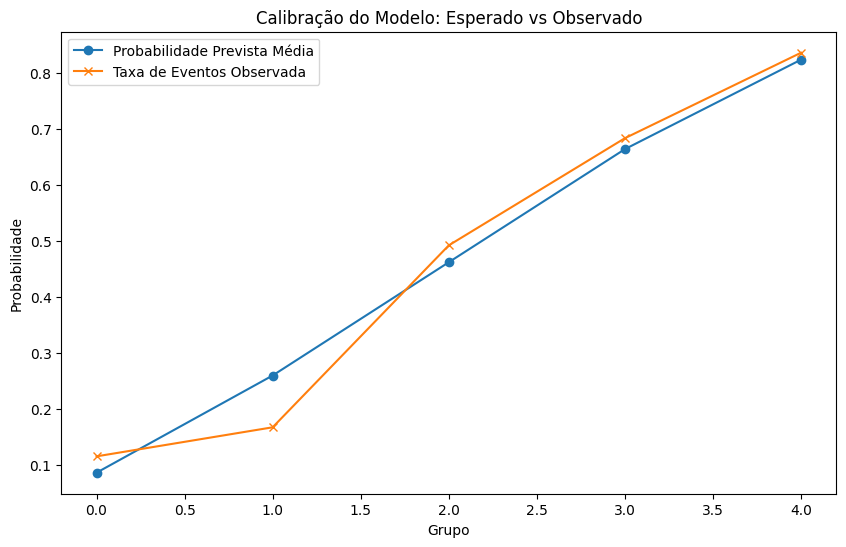

In [70]:
# Preparando os dados (substitua isso pelo seu DataFrame e variáveis)
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

# Ajustando o modelo
modelo = LogisticRegression()
modelo.fit(X, y)

# Calculando a probabilidade de evento predita
df['prob_predita'] = modelo.predict_proba(X)[:, 1]

# Categorizando em 5 grupos
df['grupo_prob'] = pd.qcut(df['prob_predita'], 5, labels=False)

media_prob_grupo = df.groupby('grupo_prob')['prob_predita'].mean()

taxa_eventos_grupo = df.groupby('grupo_prob')['flag_doente'].mean()

# Plotando
plt.figure(figsize=(10, 6))
plt.plot(media_prob_grupo.index, media_prob_grupo, marker='o', label='Probabilidade Prevista Média')
plt.plot(taxa_eventos_grupo.index, taxa_eventos_grupo, marker='x', label='Taxa de Eventos Observada')
plt.xlabel('Grupo')
plt.ylabel('Probabilidade')
plt.title('Calibração do Modelo: Esperado vs Observado')
plt.legend()
plt.show()


5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [71]:
from sklearn.metrics import accuracy_score

y_pred = modelo.predict(X)
acuracia = round(accuracy_score(y, y_pred), 3)

print(f"Acurácia do Modelo: {acuracia}")

Acurácia do Modelo: 0.772


In [72]:
from sklearn.metrics import roc_auc_score

y_probs = modelo.predict_proba(X)[:, 1]  # Probabilidades da classe positiva
gini = round((2 * roc_auc_score(y, y_probs) - 1), 3)

print(f"Coeficiente GINI: {gini}")

Coeficiente GINI: 0.663


In [73]:
from scipy.stats import ks_2samp

# Calculando a estatística KS
def calc_ks(y, y_prob):
    df_ks = pd.DataFrame({'y': y, 'y_prob': y_prob})
    df_ks = df_ks.sort_values(by='y_prob', ascending=False)
    df_ks['y_cum'] = df_ks['y'].cumsum() / df_ks['y'].sum()
    df_ks['n_cum'] = (1 - df_ks['y']).cumsum() / (1 - df_ks['y']).sum()
    ks_statistic = np.max(np.abs(df_ks['y_cum'] - df_ks['n_cum']))
    return ks_statistic

ks_statistic = round(calc_ks(y, y_probs), 3)

print(f"Estatística KS: {ks_statistic}")

Estatística KS: 0.597


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [87]:
df = pd.read_csv('processed.cleveland.data', 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])

# Criando variável alvo
df['flag_doente'] = (df['num'] != 0).astype(int)

# Dividindo dados em treino e teste
X = df[['age', 'sex', 'cp', 'trestbps']]
y = df['flag_doente']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adicionando constante
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Ajustando o modelo
model = sm.Logit(y_train, X_train_const).fit()

# Resumindo estatísticas do modelo
print(model.summary())

# Previsões
y_pred_prob = model.predict(X_test_const)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]

print(f'Gini Antes: {gini}')
print(f'Gini Atual: {round(roc_auc_score(y_test, y_pred_prob), 3)}')

Optimization terminated successfully.
         Current function value: 0.509524
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  242
Model:                          Logit   Df Residuals:                      237
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.2577
Time:                        20:41:53   Log-Likelihood:                -123.30
converged:                       True   LL-Null:                       -166.12
Covariance Type:            nonrobust   LLR p-value:                 1.117e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1468      1.757     -6.345      0.000     -14.590      -7.704
age            0.0672      0.